In [113]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import PIL

%matplotlib inline

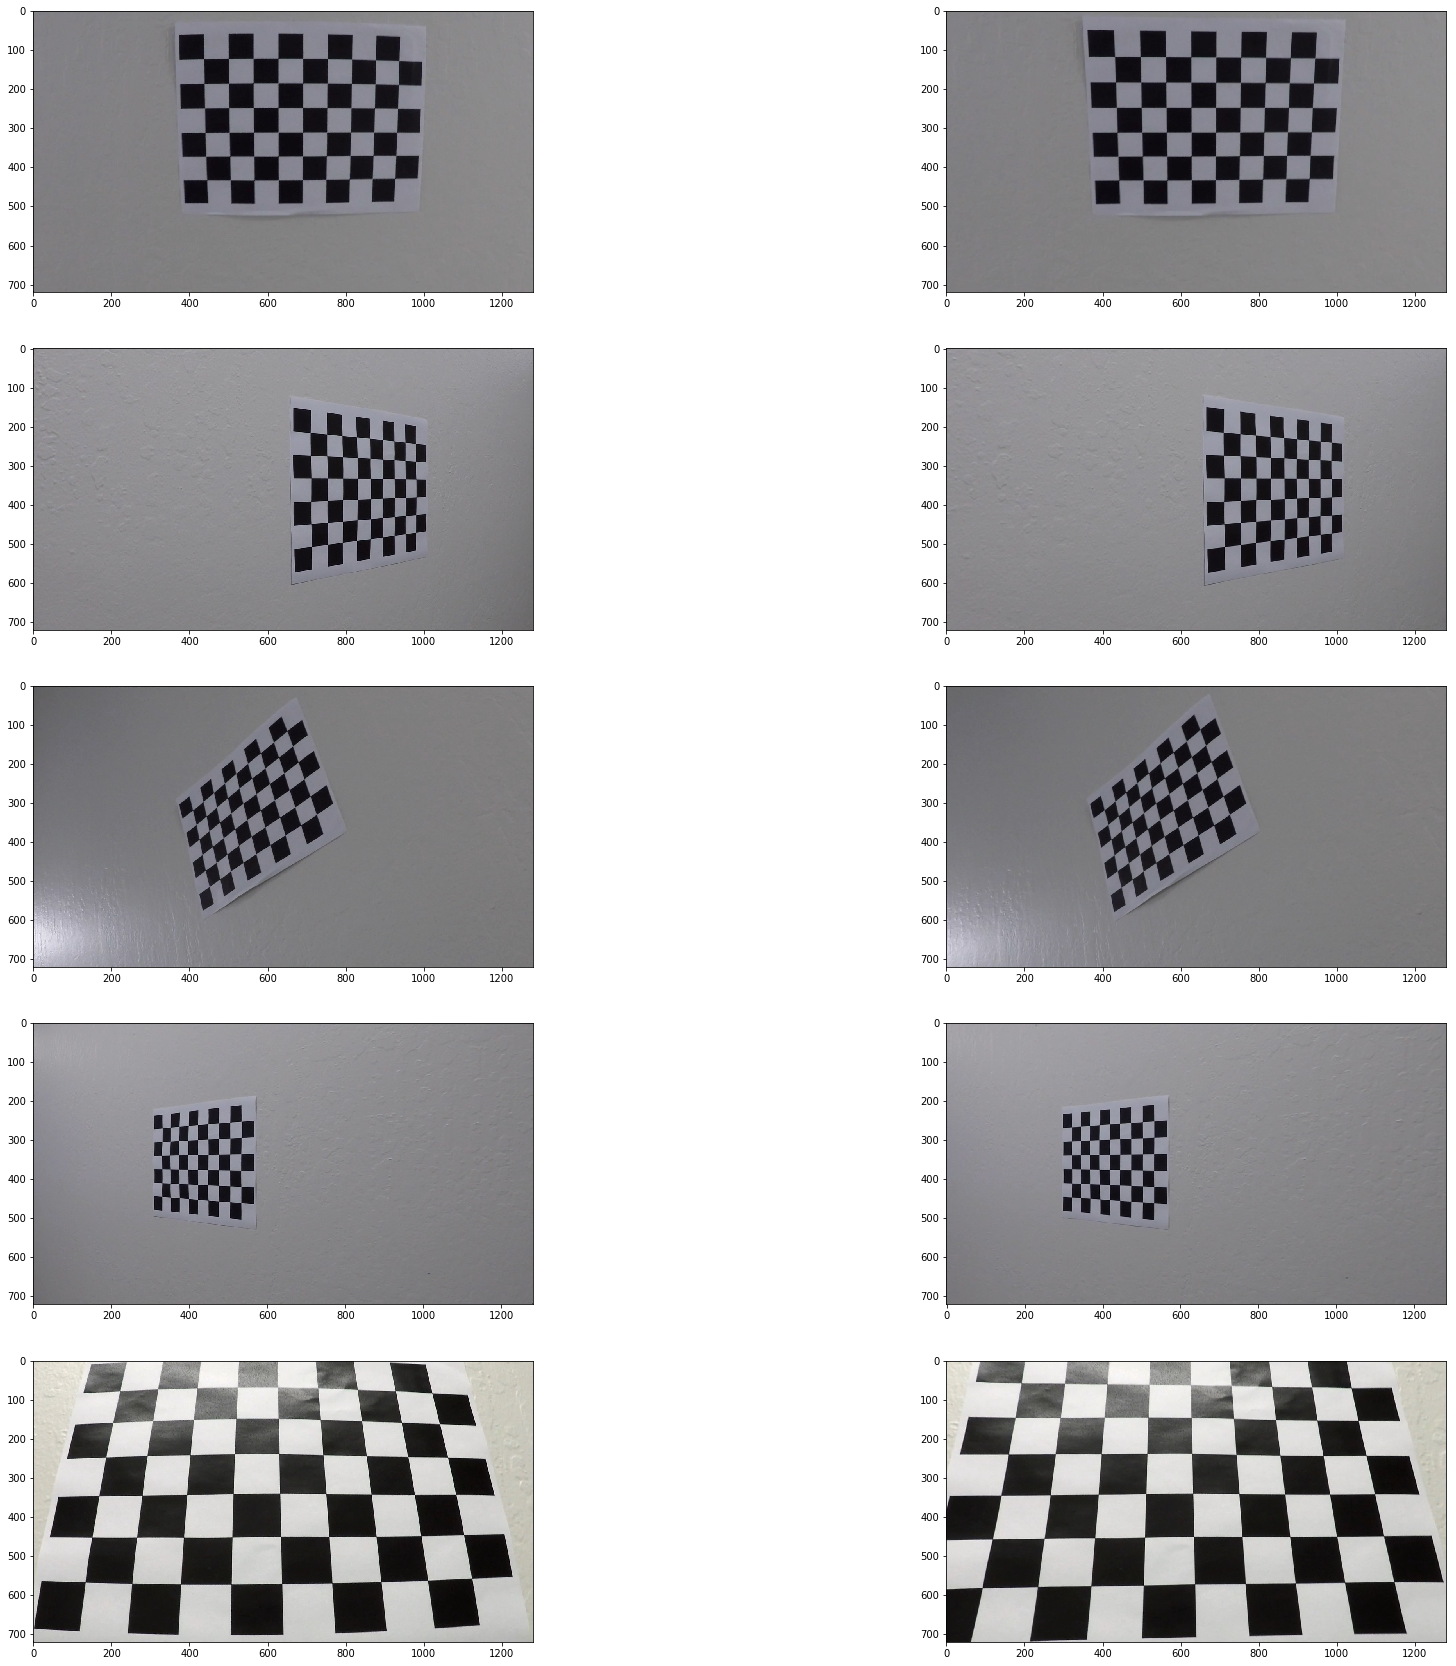

In [107]:


class Undistortor:
    def __init__(self):
        numx, numy = 9, 6
        objp = np.zeros((numx*numy, 3), np.float32)
        objp[:, :2] = np.mgrid[0:numx, 0:numy].T.reshape(-1, 2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Make a list of calibration images
        images = glob.glob('./camera_cal/calibration*.jpg')

        # Step through the list and search for chessboard corners
        for fname in images:
            img = mpimg.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (numx, numy), None)

            # If found, add object points, image points
            if ret:
                objpoints.append(objp)
                imgpoints.append(corners)
        
        ret, self.mtx, self.dist, _, _ = cv2.calibrateCamera(
            objpoints, imgpoints, gray.shape[::-1], None, None
        )

    def undistort(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def plot(self):
        images = glob.glob('./camera_cal/calibration*.jpg')
        fig, axs = plt.subplots(5, 2, figsize=(30,30))
        for idx, ax in enumerate(axs):
            img = mpimg.imread(images[idx])
            ax[0].imshow(img)
            ax[1].imshow(self.undistort(img))
        plt.show()
        
UNDISTORTOR = Undistortor()
UNDISTORTOR.plot()

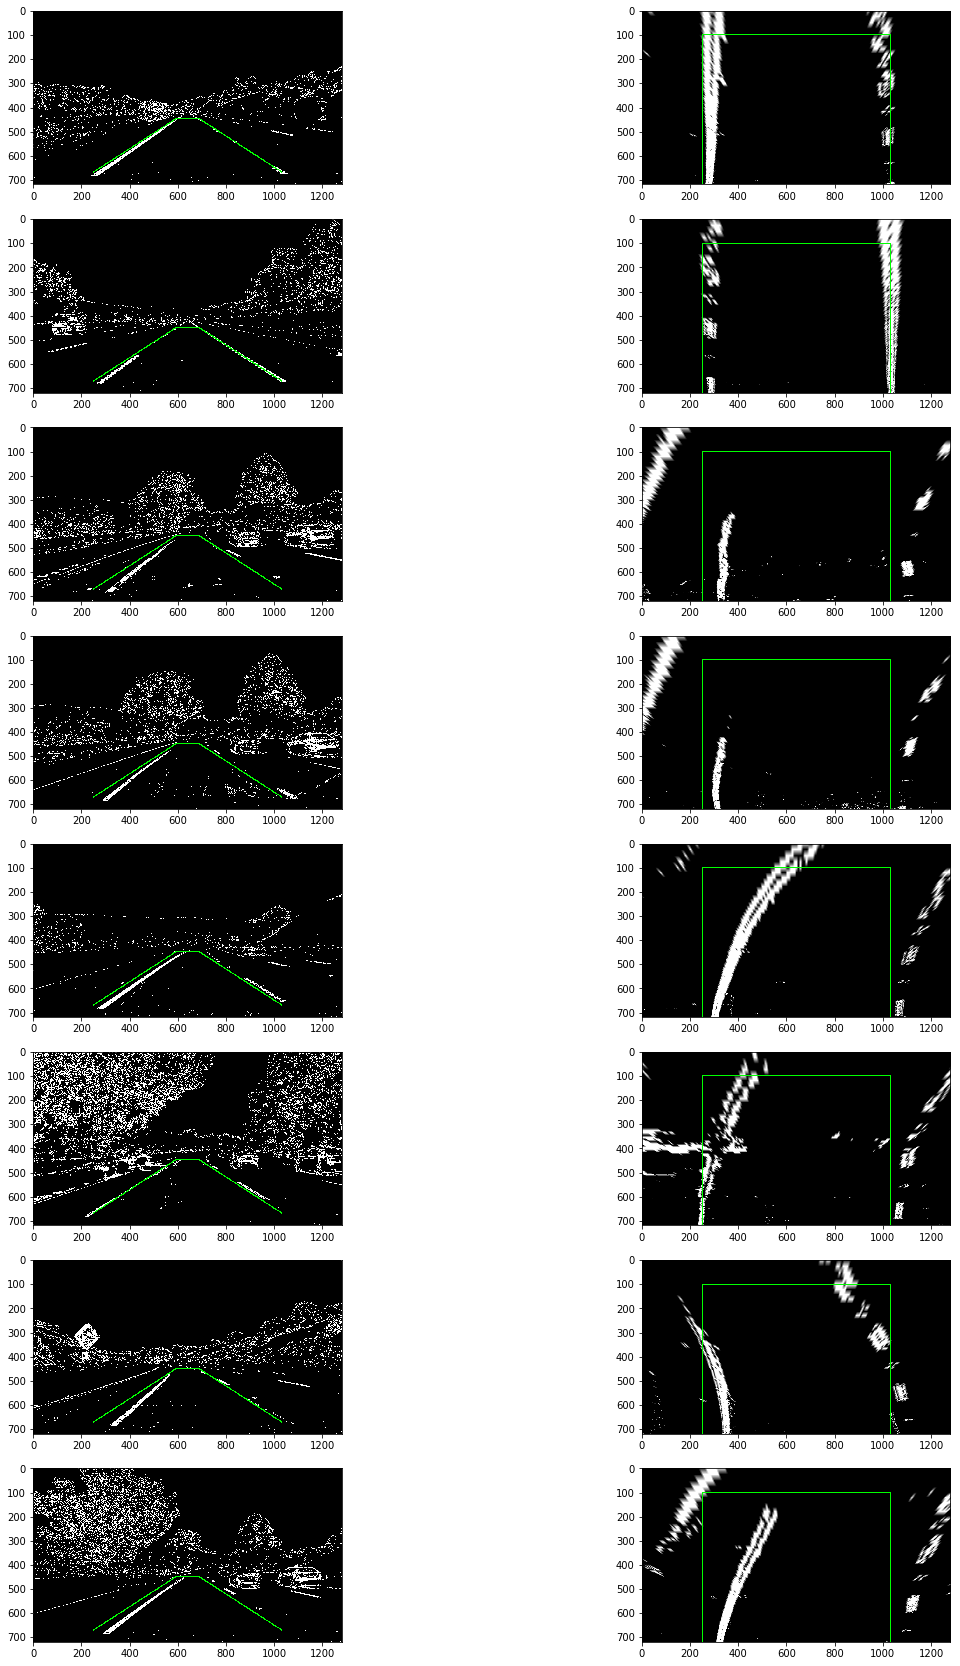

In [75]:
class Warper:
    def __init__(self):
        self.height, self.width = 720, 1280
        x_bot_off = 250
        x_top_off = 591
        y_bot_off = 50
        y_top_off = 450
        self.src = [[x_bot_off, self.height-y_bot_off],
                    [x_top_off, y_top_off], 
                    [self.width-x_top_off, y_top_off], 
                    [self.width-x_bot_off, self.height-y_bot_off]]
        self.dst = [
            [x_bot_off, self.height], 
            [x_bot_off, 100], 
            [self.width-x_bot_off, 100], 
            [self.width-x_bot_off, self.height]
        ]
        self.M = cv2.getPerspectiveTransform(np.float32(self.src), np.float32(self.dst))
        self.Minv = cv2.getPerspectiveTransform(np.float32(self.dst), np.float32(self.src))

    def warp(self, img):
        return cv2.warpPerspective(img, self.M, (self.width, self.height), flags=cv2.INTER_LINEAR)
    
    def unwarp(self, img):
        return cv2.warpPerspective(img, self.Minv, (self.width, self.height), flags=cv2.INTER_LINEAR)
    
    def draw_lines(self, img, lines, color=[0, 255, 0], thickness=3):
        copied = np.copy(img)
        for line in lines:
            x1,y1,x2,y2 = line
            cv2.line(copied, (x1, y1), (x2, y2), color, thickness)
        return copied
    
    def plot(self):
        images = glob.glob('./test_images/straight*.jpg') + glob.glob('./test_images/test*.jpg')
        fig, axs = plt.subplots(8, 2, figsize=(20,30))
        binarizor = Binarizor()
        line1 = [self.src[0]+self.src[1], self.src[1]+self.src[2], self.src[2]+self.src[3], self.src[3]+self.src[-1]]
        line2 = [self.dst[0]+self.dst[1], self.dst[1]+self.dst[2], self.dst[2]+self.dst[3], self.dst[3]+self.dst[-1]]
        for idx, ax in enumerate(axs):
            img = mpimg.imread(images[idx])
            img = binarizor.binarize(img)
            img = img*255
            img = np.dstack(( img, img, img))
            ax[0].imshow(self.draw_lines(img,line1))
            ax[1].imshow(self.draw_lines(self.warp(img),line2))
        plt.show()
        
Warper().plot()

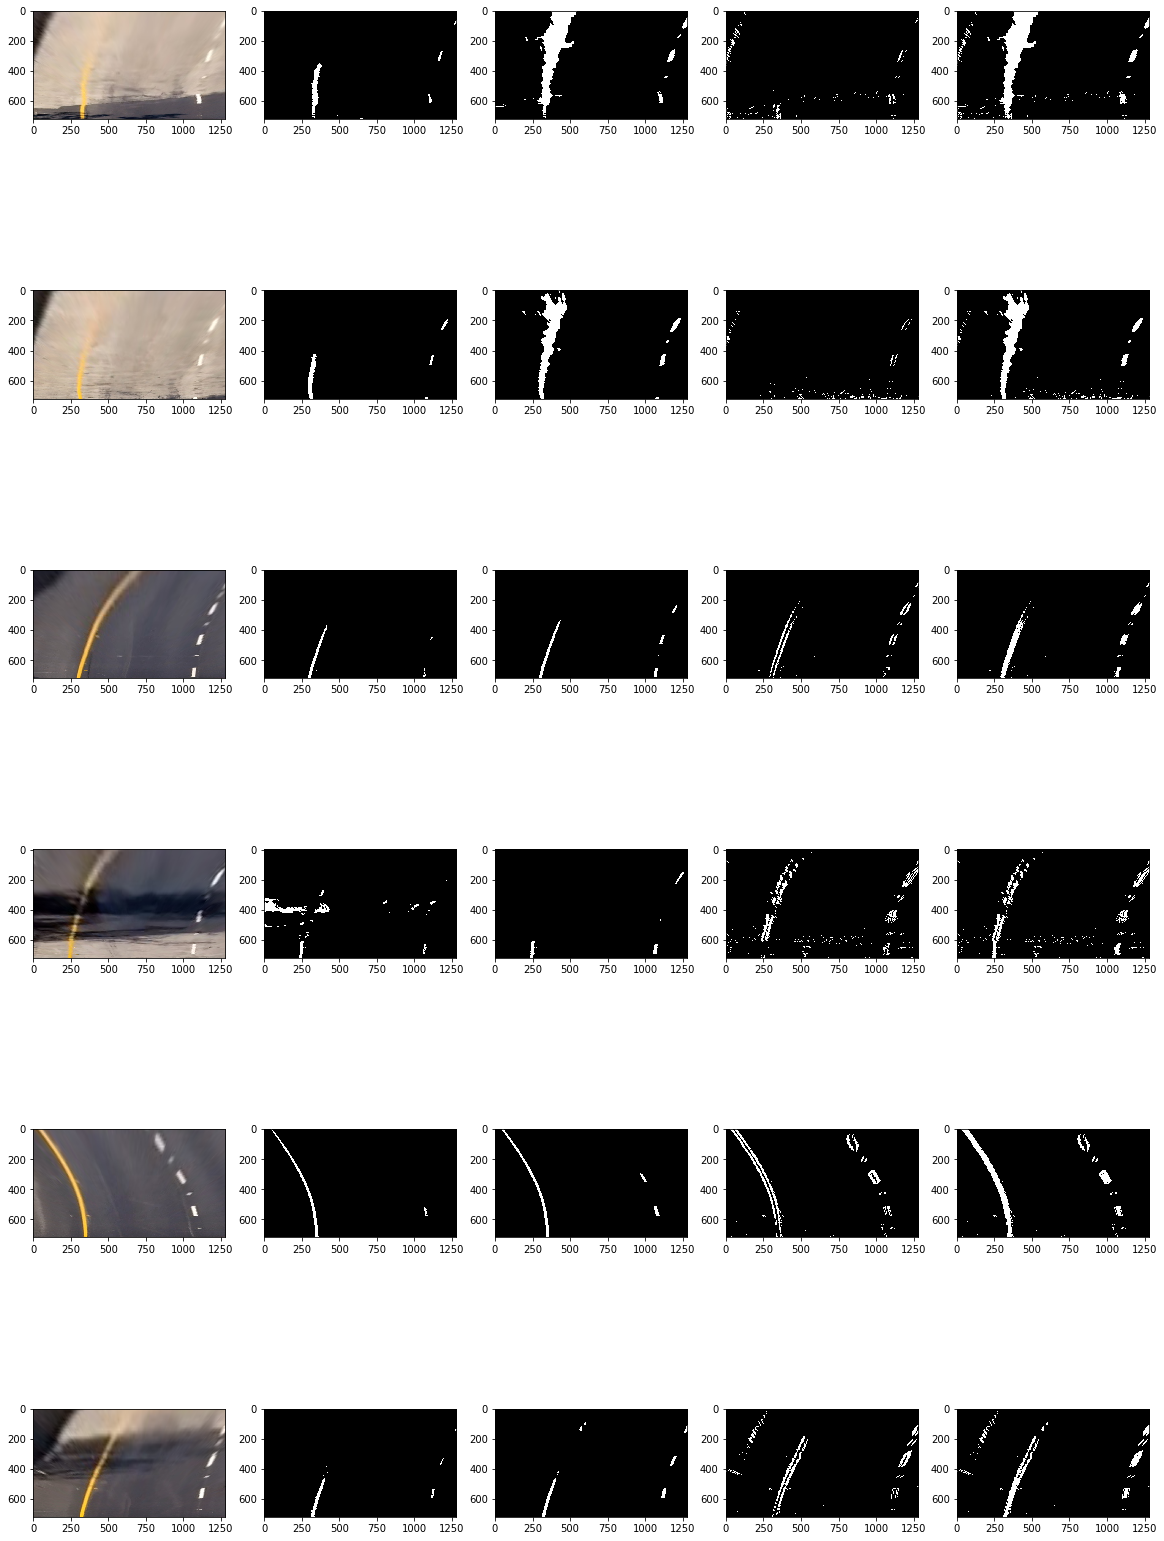

In [100]:
class Binarizor:
    def form_s_binary(self, img):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

        s_channel = hls[:,:,-1]
        
        # Threshold color channel
        s_thresh_min = 170
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        return s_binary
    
    def form_r_binary(self, img):
        # Convert to HLS color space and separate the S channel
        # Note: img is the undistorted image
        s_channel = np.mean(img[:,:,0:1], axis=2)
        
        # Threshold color channel
        s_thresh_min = 220
        s_thresh_max = 255
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        return s_binary
    
    def form_sobelx_binary(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Sobel x
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 20
        thresh_max = 100
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        return sxbinary
    
    def dir_threshold(self, img, sobel_kernel=11, thresh=(0, np.pi/8)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(sobely, sobelx)
#         print(np.min(absgraddir), np.max(absgraddir))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(25, 255)):

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output
        
    def binarize(self, img):
        # Stack each channel to view their individual contributions in green and blue respectively
        # This returns a stack of the two binary images, whose components you can see as different colors
        sxbinary = self.form_sobelx_binary(img)
        s_binary = self.form_s_binary(img)
        rg_binary = self.form_r_binary(img)
        dir_threshold = self.dir_threshold(img)
        # Combine the two binary thresholds
        combined_binary = np.zeros_like(sxbinary)
        combined_binary[
            ((rg_binary == 1) | (sxbinary == 1))                
#                  & (dir_threshold == 1)
        ] = 1
        return combined_binary

    def ret_img(self, img):
        return img
    
    def plot(self):
        images = glob.glob('./test_images/test*.jpg')
        funcs = [
            self.ret_img,
            self.form_s_binary,
            self.form_r_binary,
            self.form_sobelx_binary,
            #self.mag_thresh,
            #self.dir_threshold,
            self.binarize
        ]
        warper = Warper()
        fig, axs = plt.subplots(6, len(funcs), figsize=(20,30))
        for idx, ax in enumerate(axs):
            img = mpimg.imread(images[idx])
            img = warper.warp(img)
            for idx, func in enumerate(funcs):
                ax[idx].imshow(func(img), cmap='gray')
        plt.show()
        
Binarizor().plot()

In [101]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [173]:
class Fitter:
    def __init__(self, warper):
        # Number of windows
        self.nwindows = 9
        # Minimum number of pixels found to recenter window
        self.minpix = 50
        # Set the width of the windows +/- margin
        self.margin = 100
        
        self.warper = warper
        self.prev_left_line = Line()
        self.prev_right_line = Line()
        
        self.offset = 0
        self.left_curverad = 0
        self.right_curverad = 0
                   
    def fit_first(self, binary_warped):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & 
                              (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & 
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & 
                               (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & 
                               (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > self.minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > self.minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > self.minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         plt.figure()
#         plt.imshow(out_img)
#         plt.plot(left_fitx, ploty, color='yellow')
#         plt.plot(right_fitx, ploty, color='yellow')
#         plt.xlim(0, 1280)
#         plt.ylim(720, 0)
#         plt.show()
        
        return nonzerox, nonzeroy, left_lane_inds, right_lane_inds
    
    def fit_existing(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_fit = self.prev_left_line.current_fit
        right_fit = self.prev_right_line.current_fit
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - self.margin)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + self.margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - self.margin)) &
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + self.margin)))  
        
        return nonzerox, nonzeroy, left_lane_inds, right_lane_inds
    
    def fit_points(self, binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds):
        # Fit a second order polynomial to each
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        self.prev_left_line.current_fit = left_fit
        self.prev_left_line.detected = True
        self.prev_right_line.current_fit = right_fit
        self.prev_right_line.detected = True
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Calculate lane offset
        lane_width = (right_fitx[-1] - left_fitx[-1])
        self.offset = (binary_warped.shape[1] - lane_width)/ (2*lane_width)
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        y_eval = np.max(ploty)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        self.left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        self.right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        return left_fitx, right_fitx, ploty

    
    def form_result(self, binary_warped, orig, left_fitx, right_fitx, ploty):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = self.warper.unwarp(color_warp) 
        # Combine the result with the original image

        result = cv2.addWeighted(orig, 1, newwarp, 0.3, 0)
#         plt.figure()
#         plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
#         plt.show()
        return result

    def fit(self, binary_warped, orig):
        if self.prev_left_line.detected and self.prev_right_line.detected:
            nonzerox, nonzeroy, left_lane_inds, right_lane_inds = self.fit_existing(binary_warped)
        else:
            nonzerox, nonzeroy, left_lane_inds, right_lane_inds = self.fit_first(binary_warped)
        left_fitx, right_fitx, ploty =  self.fit_points(
            binary_warped, nonzerox, nonzeroy, left_lane_inds, right_lane_inds)
        return self.form_result(binary_warped, orig, left_fitx, right_fitx, ploty)
        
        

In [180]:
class Pipeline:
    def __init__(self):
        # Use pre-allocated undistortor so you we don't need to recalculate the weights.
        self.undistortor = UNDISTORTOR
        self.binarizor = Binarizor()
        self.warper = Warper()
        self.fitter = Fitter(self.warper)
        
    def run(self, img):
        undist = self.undistortor.undistort(img)
        combined_binary = self.binarizor.binarize(undist)
        binary_warped = self.warper.warp(combined_binary)
        fitted = self.fitter.fit(binary_warped, img)
        img = PIL.Image.fromarray(fitted, mode='RGB')
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("/usr/share/fonts/truetype/droid/DroidSans.ttf", 56)
        draw.text((0, 0),"{0:.2f} ft\n{1:.2f} m\n{2:.2f} m".format(
            self.fitter.offset,
            self.fitter.left_curverad, 
            self.fitter.right_curverad),(255,255,255),font=font)
        
        return np.array(img)
        


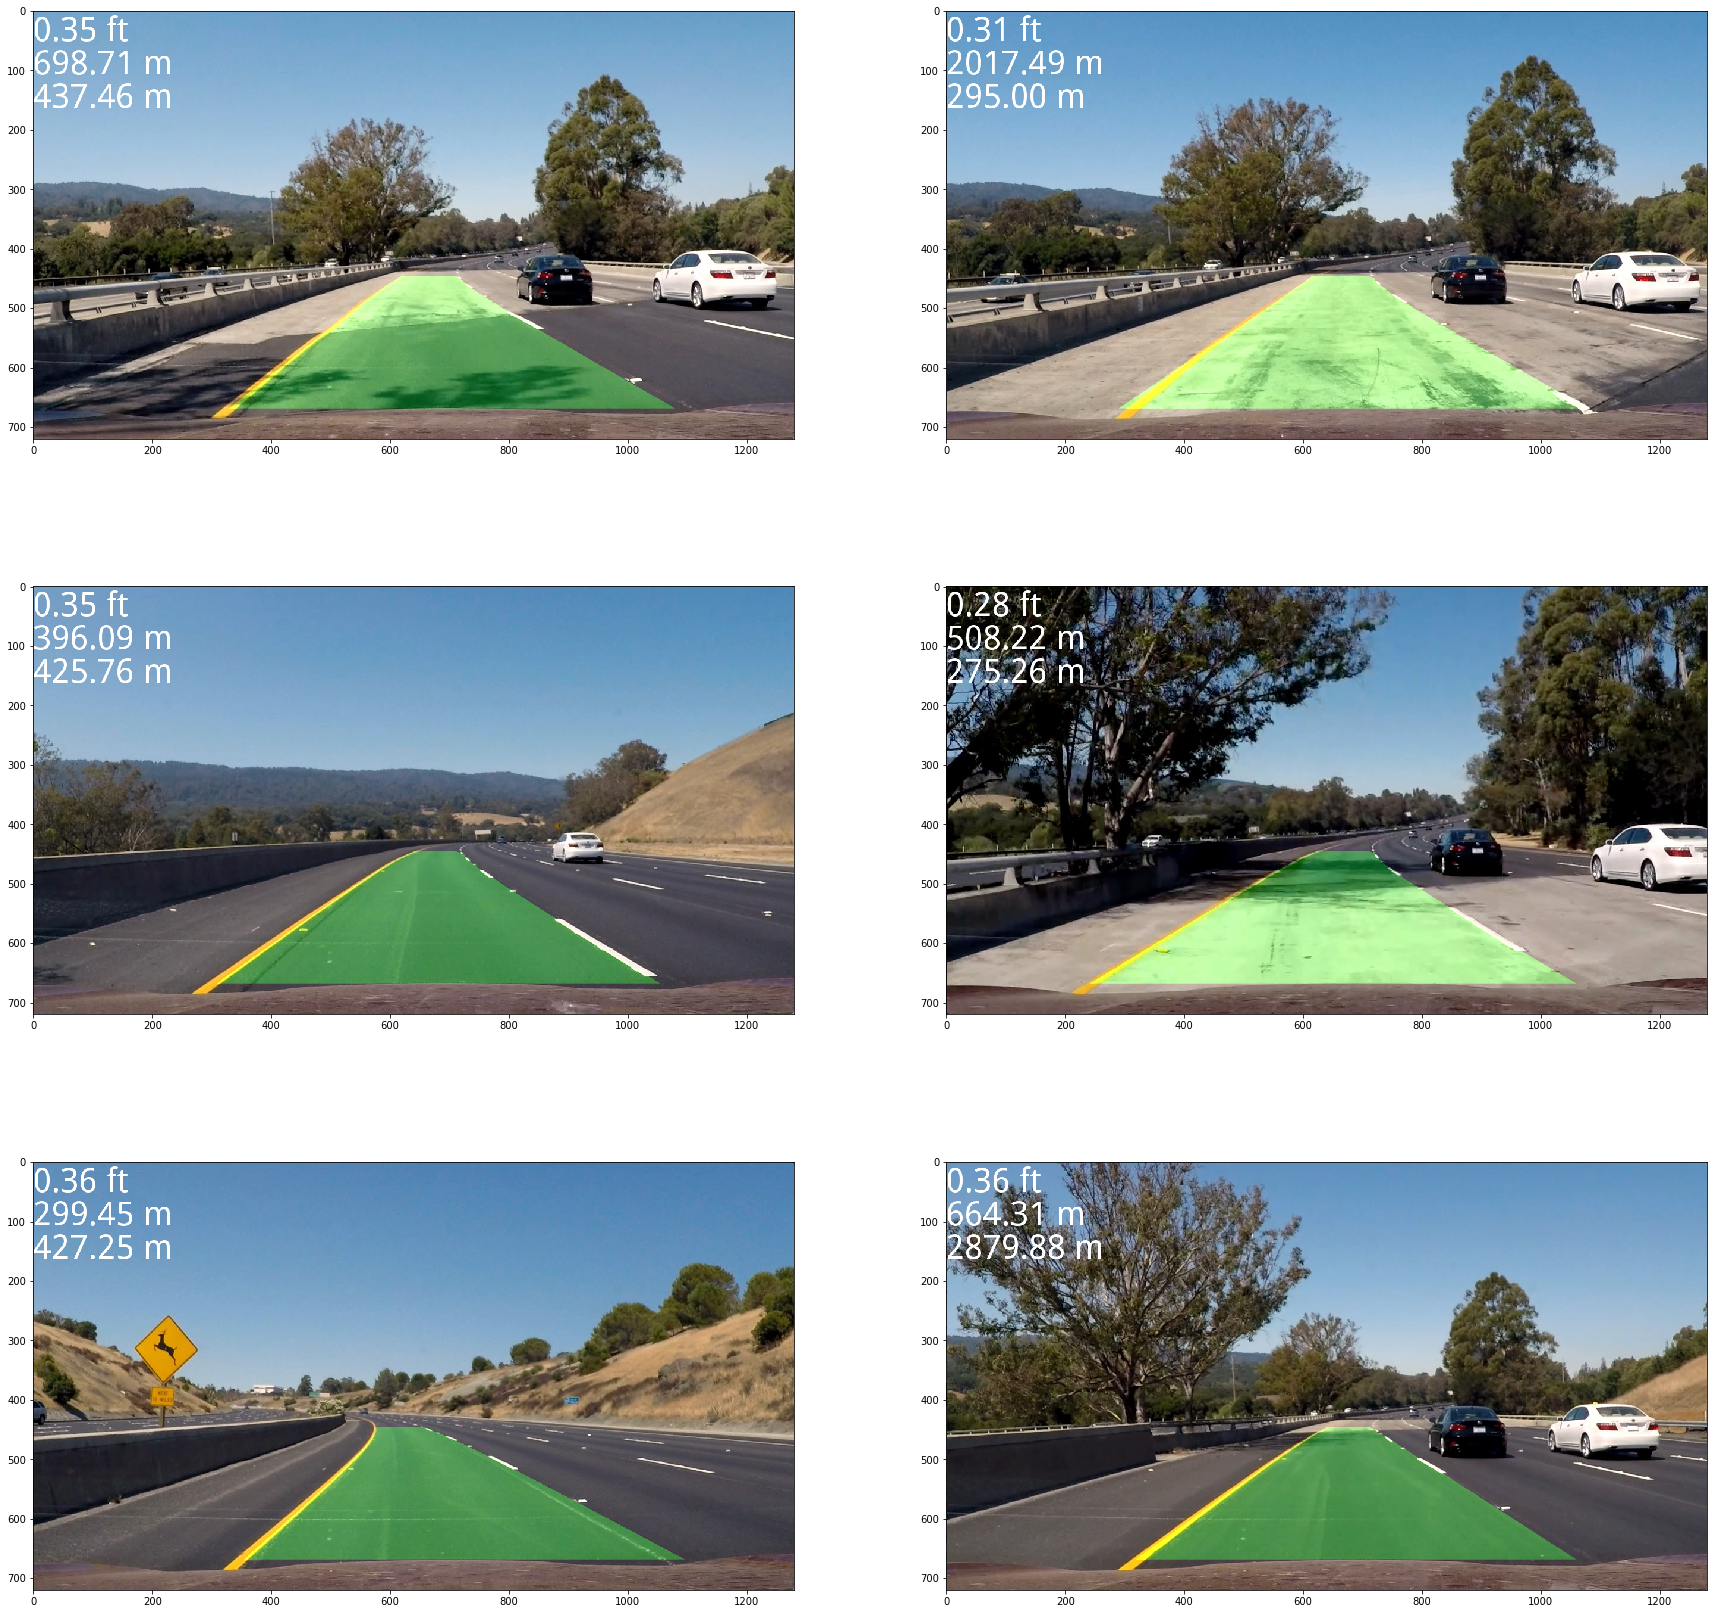

In [181]:
images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(30,30))
cnt = 0
for ax in axs:
    for x in ax:
        img = mpimg.imread(images[cnt])
        pipeline = Pipeline()
        img = pipeline.run(img)
        x.imshow(img)
        cnt += 1
plt.show()

In [182]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline = Pipeline()
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    return pipeline.run(image)

white_output = './fitted.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./fitted.mp4
[MoviePy] Writing video ./fitted.mp4


100%|█████████▉| 1260/1261 [04:27<00:00,  4.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./fitted.mp4 

CPU times: user 10min 15s, sys: 7.88 s, total: 10min 23s
Wall time: 4min 28s


In [183]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))